In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def load_data(image_dir):
    images, labels = [], []
    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                    images.append(os.path.join(folder_path, img_name))
                    labels.append(folder_name)  # Class label
    print(f"Total images found: {len(images)}")
    print(f"Classes found: {set(labels)}")
    return images, labels

In [3]:
IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images"  # Replace with actual directory
images, labels = load_data(IMAGE_DIR)

Total images found: 35126
Classes found: {'Mild', 'Severe', 'Moderate', 'No_DR', 'Proliferate_DR'}


In [4]:
def oversample_data(images, labels, max_size=None):
    label_counts = Counter(labels)
    max_class_count = max(label_counts.values())  # Get max class size
    
    if max_size:
        max_class_count = min(max_size, max_class_count)  # Limit oversampling

    new_images, new_labels = [], []
    for label, count in label_counts.items():
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]

        # Oversample to max_class_count
        if count < max_class_count:
            oversample_count = max_class_count - count
            oversampled_images = np.random.choice(label_images, oversample_count, replace=True)
            new_images.extend(oversampled_images)
            new_labels.extend([label] * oversample_count)

        # Add original images
        new_images.extend(label_images[:max_class_count])  
        new_labels.extend([label] * min(count, max_class_count))

    print(f"📊 Class distribution after oversampling: {Counter(new_labels)}")
    return new_images, new_labels

In [5]:
# ✅ Balance dataset
train_images, train_labels = oversample_data(images, labels, max_size=7000)


📊 Class distribution after oversampling: Counter({'Mild': 7000, 'Proliferate_DR': 7000, 'Moderate': 7000, 'No_DR': 7000, 'Severe': 7000})


In [6]:
# ✅ Split into train/test
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

In [7]:
# ✅ Define Teacher Model
def create_finetuned_teacher_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Enable fine-tuning

    # Freeze the first 50 layers for stability
    for layer in base_model.layers[:50]:  
        layer.trainable = False

    # Custom layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)  # Multi-class classification

    model = models.Model(inputs=base_model.input, outputs=output)

    # ✅ Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
# ✅ Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Convert to Pandas DataFrame
train_df = pd.DataFrame({"filename": train_images, "class": train_labels})
test_df = pd.DataFrame({"filename": test_images, "class": test_labels})


In [9]:
# ✅ Create Data Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 28000 validated image filenames belonging to 5 classes.
Found 7000 validated image filenames belonging to 5 classes.


In [10]:
# ✅ Compute Class Weights
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(num_classes)}


In [11]:
# ✅ Train Teacher Model
teacher_model = create_finetuned_teacher_model(num_classes)

history = teacher_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weights_dict
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 1431s 2s/step - accuracy: 0.4708 - loss: 1.2395 - val_accuracy: 0.2260 - val_loss: 3.1008
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1427s 2s/step - accuracy: 0.7191 - loss: 0.6568 - val_accuracy: 0.4080 - val_loss: 1.8923
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1417s 2s/step - accuracy: 0.8183 - loss: 0.4545 - val_accuracy: 0.5919 - val_loss: 1.3362
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1408s 2s/step - accuracy: 0.8826 - loss: 0.3038 - val_accuracy: 0.7894 - val_loss: 0.5699
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1467s 2s/step - accuracy: 0.9180 - loss: 0.2213 - val_accuracy: 0.8023 - val_loss: 0.5442
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1433s 2s/step - accuracy: 0.9434 - loss: 0.1573 - val_accuracy: 0.7266 - val_loss: 1.0266
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1445s 2s/step - accuracy: 0.9558 - loss: 0.1301 - val_accuracy: 0.7647 - val_loss: 1.0143
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1418s 2s/step - accuracy: 0.9590 - loss: 0.1207 - val_accurac

In [15]:
# ✅ Evaluate Teacher Model & Compute Metrics
def evaluate_teacher_model(model, test_images, test_labels, class_indices):
    # Convert labels to numerical indices
    class_indices_inv = {v: k for k, v in class_indices.items()}  # Reverse mapping
    
    # Preprocess test images
    X_test, y_test = [], []
    for img_path, label in zip(test_images, test_labels):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize
        X_test.append(img_array)
        y_test.append(class_indices[label])  # Convert label to class index

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class index

    # Compute Metrics
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=list(class_indices.keys())))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_indices.keys(),
                yticklabels=class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute Accuracy per Class
    class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    for class_name, acc in zip(class_indices.keys(), class_accuracies):
        print(f"✅ Accuracy for class {class_name}: {acc:.2%}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 148s 676ms/step

📊 Classification Report:

                precision    recall  f1-score   support

          Mild       0.66      0.93      0.77      1400
      Moderate       0.80      0.44      0.57      1400
         No_DR       0.64      0.64      0.64      1400
Proliferate_DR       0.92      1.00      0.96      1400
        Severe       0.98      0.94      0.96      1400

      accuracy                           0.79      7000
     macro avg       0.80      0.79      0.78      7000
  weighted avg       0.80      0.79      0.78      7000



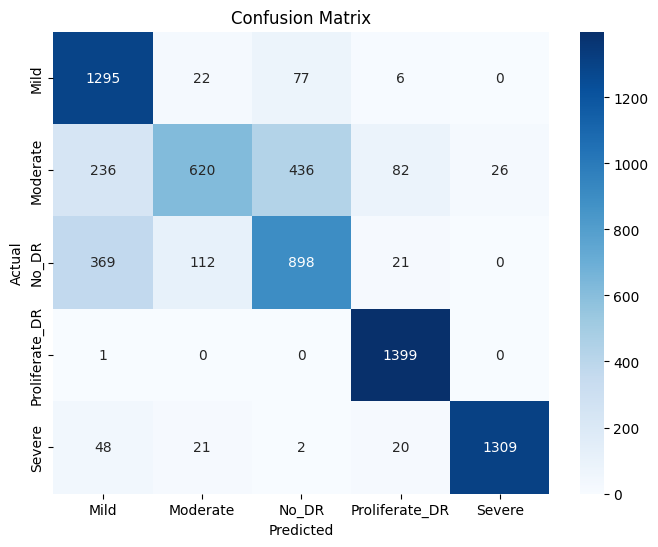

✅ Accuracy for class Mild: 92.50%
✅ Accuracy for class Moderate: 44.29%
✅ Accuracy for class No_DR: 64.14%
✅ Accuracy for class Proliferate_DR: 99.93%
✅ Accuracy for class Severe: 93.50%


In [16]:
# ✅ Run evaluation
evaluate_teacher_model(teacher_model, test_images, test_labels, train_generator.class_indices)


In [17]:
# ✅ Save Model
teacher_model.save("teacher_model_mobilenetv2.h5")
print("✅ Teacher Model saved successfully!")

✅ Teacher Model saved successfully!
